### Import packages

Note that some packages are local python scripts created to enable the proper use of the Notebook

In [1]:
import numpy as np
import torch

from torch_geometric.loader import LinkNeighborLoader

import matplotlib.pyplot as plt


c:\Users\James\Projects\Papers\ER2023\envML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Basic configurations

Define the main options for the Training and execution

In [43]:
EPOCHS=1000
LEARNING_RATE=0.001
STRINGS_ENCODER="all-MiniLM-L6-v2"
SPLIT = "80/10/10"
BATCH = "_batch"
ADD_NEGATIVE_TRAINING = False

# Define dataset used
DATASET_LABEL = "AB"

In [44]:
import glob
from os import path as osp
import json

# important directories
data_path = osp.join('../Data/', DATASET_LABEL)
save_path_csv = osp.join('../Comparison/', DATASET_LABEL)

save_path_csv = osp.join(save_path_csv, 'results' + BATCH + '.csv')

# Read JSON to get extra parameters in the graph
json_path = osp.join('../Views/Recommended_View/src-gen/', "recommended.json")
parameters_exist = len(json_path) != 0
parameters_for_gnn = None
if parameters_exist:
    parameters_for_gnn = json_path

IGNORE_ATTRIBUTES_LEFT = None
IGNORE_ATTRIBUTES_RIGHT = None
with open(parameters_for_gnn) as json_data:
    parameters = json.load(json_data)

    for relation_name, relation_props in parameters.items():
        class_left = relation_props['CLASS_LEFT']
        class_right = relation_props['CLASS_RIGHT']
        rev_relation_name = "rev_" + relation_name

        UNIQUE_ID_LEFT = relation_props['UNIQUE_ID_LEFT']
        UNIQUE_ID_RIGHT = relation_props['UNIQUE_ID_RIGHT']

        IGNORE_ATTRIBUTES_LEFT = relation_props['IGNORE_ATTRIBUTES_LEFT']
        IGNORE_ATTRIBUTES_RIGHT = relation_props['IGNORE_ATTRIBUTES_RIGHT']


### Print functions for the performance curves

Functions to print both ROC (Receiver Operating Characteristic) curve and PR (Precision-Recall) curve

In [45]:
def print_pr_curve(precision, recall, title, pr_auc, no_skill):
    #create precision recall curve
    _, ax = plt.subplots()
    ax.plot(recall, precision, color='purple', label='AUC = %0.4f' % pr_auc)
    ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

    #add axis labels to plot
    ax.set_title(title)
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    plt.legend(loc='best')
    #display plot
    plt.show

def print_roc_curve(fpr, tpr, title, roc_auc):
    #create ROC curve
    _, ax = plt.subplots()
    ax.plot(fpr, tpr, color='purple', label='AUC = %0.4f' % roc_auc)
    ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

    #add axis labels to plot
    ax.set_title(title)
    ax.set_ylabel('True Positive Rate(TPR)')
    ax.set_xlabel('False Positive Rate(FPR)')

    plt.legend(loc='best')
    #display plot
    plt.show()

### Configuration of EMF models

In [46]:
from pyecore.resources import ResourceSet, URI

# Custom functions get Heterodata from EMF model
from utils.to_graph import Func

# Register the metamodels in the resource set    
resource_set = ResourceSet()
modeling_resources_path = osp.join('../Modeling_Resources/')

ecore_path_a = osp.join(modeling_resources_path, 'metamodels/A.ecore')
ecore_path_b =osp.join(modeling_resources_path, 'metamodels/B.ecore')

resource_a = resource_set.get_resource(URI(ecore_path_a))
mm_root_a = resource_a.contents[0]
resource_b = resource_set.get_resource(URI(ecore_path_b))
mm_root_b = resource_b.contents[0]

resource_set.metamodel_registry[mm_root_a.nsURI] = mm_root_a
resource_set.metamodel_registry[mm_root_b.nsURI] = mm_root_b

if IGNORE_ATTRIBUTES_LEFT is not None:
    features_to_ignore_left = IGNORE_ATTRIBUTES_LEFT.split(",")
else:
    features_to_ignore_left = None
if IGNORE_ATTRIBUTES_RIGHT is not None:
    features_to_ignore_right = IGNORE_ATTRIBUTES_RIGHT.split(",")
else:
    features_to_ignore_right = None

dataset_func = Func(sentence_encoding_name=STRINGS_ENCODER, features_to_ignore_left=features_to_ignore_left, features_to_ignore_right=features_to_ignore_right, unique_id_left=UNIQUE_ID_LEFT, unique_id_right=UNIQUE_ID_RIGHT)

### Create the Hetero data

The following code reads the two .xmi serialized models and create a HeteroData for use in PyG functions. The .csv file with the example relations is used to create the edge_index. 

In [47]:
# Register the models in the resource set
xmi_path_left = glob.glob(osp.join(data_path, "DatasetLeft.xmi"))[0]
m_resource_left = resource_set.get_resource(URI(xmi_path_left))
model_root_left = m_resource_left.contents

xmi_path_right = glob.glob(osp.join(data_path, "DatasetRight.xmi"))[0]
m_resource_right = resource_set.get_resource(URI(xmi_path_right))
model_root_right = m_resource_right.contents

relations_path = glob.glob(osp.join(data_path, "Relations.csv"))
relations_exist = len(relations_path) != 0
relations_for_graph = None
if relations_exist:
    relations_for_graph = relations_path[0]  

data, left_original_mapping, right_original_mapping = dataset_func.xmi_to_graph(model_root_left, model_root_right, relations_for_graph, class_left, class_right, relation_name)

print(data)

Batches: 100%|██████████| 231/231 [00:18<00:00, 12.17it/s]

HeteroData(
  A={
    x=[610, 385],
    num_nodes=610,
    node_id=[610]
  },
  B={
    x=[7378, 387],
    num_nodes=7378,
    node_id=[7378]
  },
  (A, relates_with, B)={ edge_index=[2, 3740] }
)


### Change device

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

### Add reverse relation

In [49]:
import torch_geometric.transforms as T

 # Add a reverse (class_right, rev_relation_name, class_left) relation for message passing:
data = T.ToUndirected()(data)
del data[class_right, rev_relation_name, class_left].edge_label  # Remove "reverse" label.

### Split the data

In [50]:
# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1, # 10% of links for validation
    num_test=0.1, # 10% os links for test
    disjoint_train_ratio=0.4, # use 60% for message passing and 40% for supervision
    neg_sampling_ratio=2.0, # generate 2:1 negative edges
    add_negative_train_samples=ADD_NEGATIVE_TRAINING,
    edge_types=(class_left, relation_name, class_right),
    rev_edge_types=(class_right, rev_relation_name, class_left)
)(data)

train_edge_label_index = train_data[class_left, relation_name, class_right].edge_label_index
train_edge_label = train_data[class_left, relation_name, class_right].edge_label

print(train_data)
print(train_edge_label_index)
print(train_edge_label)

HeteroData(
  A={
    x=[610, 385],
    num_nodes=610,
    node_id=[610]
  },
  B={
    x=[7378, 387],
    num_nodes=7378,
    node_id=[7378]
  },
  (A, relates_with, B)={
    edge_index=[2, 1796],
    edge_label=[1196],
    edge_label_index=[2, 1196]
  },
  (B, rev_relates_with, A)={ edge_index=[2, 1796] }
)
tensor([[ 106,  274,   58,  ...,  335,   28,   32],
        [1152, 1567, 3554,  ..., 2803, 6528, 6612]])
tensor([1., 1., 1.,  ..., 1., 1., 1.])


### Train loader

In [51]:
# LOADERS
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=((class_left, relation_name, class_right), train_edge_label_index),
    edge_label=train_edge_label,
    batch_size=128,
    shuffle=True,
)

sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  A={
    x=[318, 385],
    num_nodes=318,
    node_id=[318],
    n_id=[318]
  },
  B={
    x=[1262, 387],
    num_nodes=1262,
    node_id=[1262],
    n_id=[1262]
  },
  (A, relates_with, B)={
    edge_index=[2, 857],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[857],
    input_id=[128]
  },
  (B, rev_relates_with, A)={
    edge_index=[2, 947],
    e_id=[947]
  }
)


### GNN architecture

Two SageConv Layers for Node embedding and a Classifier that performs the dot-product between embeddings. It also use a extra `to_hetero` transformer since it will be applied to the HeteroData objects

In [52]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

class GNN(torch.nn.Module):
    """
    This class is responsible for creating the ML model
    """

    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        """
        This method is responsible for executing the forward pass of the convolutional GNN.

        Parameters
        ----------
        x: torch.Tensor
            input tensor
        edge_index: torch.Tensor
            edge index

        Returns
        -------
        x: torch.Tensor
            output tensor
        """
        # A 2-layer GNN computation graph.
        # `ReLU` is the non-lineary function used in-between.
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class Classifier(torch.nn.Module):
    """
    The final classifier applies the dot-product between source and destination node embeddings to derive edge-level predictions
    """

    def forward(self, x_left: torch.Tensor, x_right: torch.Tensor, edge_label_index: torch.Tensor) -> torch.Tensor:
        """
        This method is responsible for executing the forward pass of the classifier.
        
        Parameters
        ----------
        x_left: torch.Tensor
            input tensor for Left class
        x_right: torch.Tensor
            input tensor for Right class
        edge_label_index: torch.Tensor
            edge label index

        Returns
        -------
        x: torch.Tensor
            output tensor
        """

        # Convert node embeddings to edge-level representations:
        edge_feat_left  = x_left[edge_label_index[0]]
        edge_feat_right = x_right[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_left * edge_feat_right).sum(dim=-1)


class Model(torch.nn.Module):
    """
    This class is responsible for creating the model with two SageConv layers with a addiotinal classifier to be used in the training.
    """

    def __init__(self, hidden_channels, data):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for A and B:
        self.left_lin = torch.nn.Linear(data[class_left].num_features, hidden_channels)
        self.right_lin = torch.nn.Linear(data[class_right].num_features, hidden_channels)
        # self.left_emb = torch.nn.Embedding(data[class_left].num_nodes, hidden_channels)
        # self.right_emb = torch.nn.Embedding(data[class_right].num_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.classifier = Classifier()

    def forward(self, data) -> torch.Tensor:
        """	
        This method is responsible for executing the forward pass of the model.

        Parameters
        ----------
        data: HeteroData
            input data

        Returns
        -------
        pred: torch.Tensor
            output tensor
        """
        
        x_dict = {
        #   class_left: self.A_lin(data[class_left].x) + self.left_emb(data[class_left].node_id),
          class_left: self.left_lin(data[class_left].x) ,#+ self.left_emb(data[class_left].node_id),
          class_right: self.right_lin(data[class_right].x) ,#+ self.right_emb(data[class_right].node_id),
        } 
        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict[class_left],
            x_dict[class_right],
            data[class_left, relation_name, class_right].edge_label_index,
        )
        return pred
    
    def get_name(self):
        return "dot_product"
    
model = Model(hidden_channels=64, data=data)

print(model)

Model(
  (left_lin): Linear(in_features=385, out_features=64, bias=True)
  (right_lin): Linear(in_features=387, out_features=64, bias=True)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (A__relates_with__B): SAGEConv(64, 64, aggr=mean)
      (B__rev_relates_with__A): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (A__relates_with__B): SAGEConv(64, 64, aggr=mean)
      (B__rev_relates_with__A): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)


### Training a Heterogeneous Link-level GNN

Training the GNN is similar to training any PyTorch model.
We move the model to the desired device, and initialize an optimizer that takes care of adjusting model parameters via stochastic gradient descent.

The training loop then iterates over the training mini-batches, applies the forward computation of the model, computes the loss from ground-truth labels and obtained predictions using binary cross entropy, and adjusts model parameters via back-propagation.

In [53]:
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=float(LEARNING_RATE))

for epoch in range(1, int(EPOCHS)):
    total_loss = total_examples = 0
    for _, sampled_data in enumerate(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data[class_left, relation_name, class_right].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    if epoch % 50 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cpu'
Epoch: 050, Loss: 8.5185
Epoch: 100, Loss: 0.9799
Epoch: 150, Loss: 0.5948
Epoch: 200, Loss: 0.5670
Epoch: 250, Loss: 0.5364
Epoch: 300, Loss: 0.5135
Epoch: 350, Loss: 0.4952
Epoch: 400, Loss: 0.4839
Epoch: 450, Loss: 0.4762
Epoch: 500, Loss: 0.4767
Epoch: 550, Loss: 0.4754
Epoch: 600, Loss: 0.4700
Epoch: 650, Loss: 0.5223
Epoch: 700, Loss: 0.5051
Epoch: 750, Loss: 0.5640
Epoch: 800, Loss: 0.5490
Epoch: 850, Loss: 0.5571
Epoch: 900, Loss: 0.5505
Epoch: 950, Loss: 0.5441


### Evaluating a Heterogeneous Link-level GNN

After training, we evaluate our model on useen data coming from the validation set.

In [57]:
# Define the validation seed edges:
edge_label_index = val_data[class_left, relation_name, class_right].edge_label_index
edge_label = val_data[class_left, relation_name, class_right].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(
        (class_left, relation_name, class_right), 
        val_data[(class_left, relation_name, class_right)].edge_label_index,
    ),
    edge_label=val_data[(class_left, relation_name, class_right)].edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data[class_left, relation_name, class_right].edge_label_index.size(1) == 3 * 128
assert sampled_data[class_left, relation_name, class_right].edge_label.min() == 0
assert sampled_data[class_left, relation_name, class_right].edge_label.max() == 1

Sampled mini-batch:
HeteroData(
  A={
    x=[283, 385],
    num_nodes=283,
    node_id=[283],
    n_id=[283]
  },
  B={
    x=[1814, 387],
    num_nodes=1814,
    node_id=[1814],
    n_id=[1814]
  },
  (A, relates_with, B)={
    edge_index=[2, 1421],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[1421],
    input_id=[384]
  },
  (B, rev_relates_with, A)={
    edge_index=[2, 1434],
    e_id=[1434]
  }
)


### Metrics and plots to evaluate the performance of GNN

100%|██████████| 3/3 [00:00<00:00, 122.01it/s]


Sample of y_true and y_score
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-0.58533335  0.03886557  0.01394796 -0.44977903 -0.2511053  -0.30128145
 -0.6715255  -0.43232155 -0.25453663 -0.35228205]
Validation ROC_AUC: 0.6975


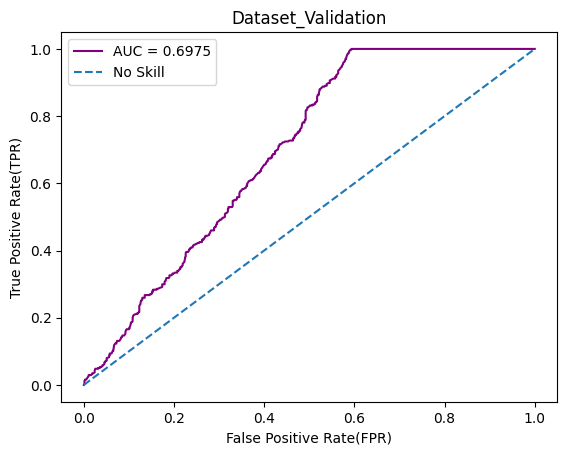

In [58]:
import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as area_curve

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data[class_left, relation_name, class_right].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

print("Sample of y_true and y_score")
print(ground_truth[:10])
print(pred[:10])

# Metric 1 - ROC
auc = roc_auc_score(ground_truth, pred)
print(f"Validation ROC_AUC: {auc:.4f}")

fpr, tpr, roc_tr = roc_curve(ground_truth, pred)
print_roc_curve(fpr, tpr, "Dataset" + "_Validation", auc)

# Metric 2 - Precision Recall
no_skill = len(ground_truth[ground_truth==1]) / len(ground_truth)
precision, recall, _ = precision_recall_curve(ground_truth, (torch.sigmoid(torch.from_numpy(pred))))
pr_auc = area_curve (recall, precision)
# print_pr_curve(precision, recall, "Dataset" + "_Validation", pr_auc, no_skill)


### Select the thresholds to be used in inferences

Area under the ROC curve : 0.697527


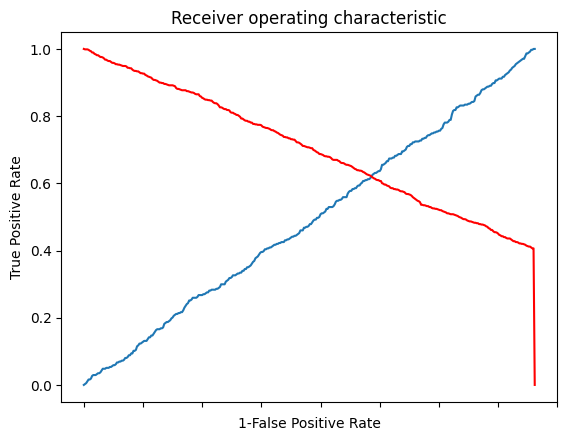

243   -0.465953
Name: thresholds, dtype: float32


In [59]:
import pandas as pd


roc_auc = area_curve(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

####################################
# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
####################################
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({
    'fpr' : pd.Series(fpr, index=i),
    'tpr' : pd.Series(tpr, index = i), 
    '1-fpr' : pd.Series(1-fpr, index = i), 
    'tf' : pd.Series(tpr - (1-fpr), index = i), 
    'thresholds' : pd.Series(roc_tr, index = i)})

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])
plt.show()

print(roc.iloc[(roc.tf-0).abs().argsort()[:1]]['thresholds'])

### Predict results to be used in the new view

In [41]:
from tqdm.auto import tqdm

model = model.cpu() 
model.eval() 

total_class_left = len(left_original_mapping) 
total_class_right = len(right_original_mapping)

threshold = -14.329353
predictions = {}

for uri_idenifier_left, left_id in tqdm(left_original_mapping.items()):
    predictions[uri_idenifier_left] = []

    left_row = torch.tensor([left_id] * total_class_right) 
    all_right_ids = torch.arange(total_class_right) 
    edge_label_index = torch.stack([left_row, all_right_ids], dim=0) 
    data[class_left, relation_name, class_right].edge_label_index = edge_label_index
    
    with torch.no_grad(): 
        pred = model(data)
    # cut off by threshold
    optimal_pred = (pred > threshold).long()
    probabilities = torch.sigmoid(pred)
    pred_labels = (probabilities > threshold).long()

    recommended_links = all_right_ids[optimal_pred == 1].tolist()

    predictions[uri_idenifier_left] = recommended_links
    #print("The {} with ID {} should be linked with the following {}:\n{}".format(class_left, uri_idenifier_left, class_right, predictions[uri_idenifier_left]), end="\n\n")


100%|██████████| 610/610 [00:08<00:00, 74.43it/s] 


### Save results in JSON to enable the definition of WeavingModel

In [42]:
predicted_path = osp.join('../Views/Recommended_View/for_recommendation', "recommendations.json")

inv_right_mapping = {v: k for k, v in right_original_mapping.items()}
json_dict = {}
#iterate over the predictions and create the JSON
for uri_idenifier_left, potential_links in predictions.items():
    json_dict[uri_idenifier_left] = [inv_right_mapping[x] for x in potential_links]

with open(predicted_path, 'w+') as f:
    json.dump(json_dict, f)


### Save metrics and Hyperparameters in CSV

In [ ]:
new_file = not osp.exists(save_path_csv)

if new_file:
    open(save_path_csv, 'w+').write(f"'Best', 'Rule', 'Desc', 'ML_Arch_Name', 'encode_features_A', 'encode_features_B', 'Training_split', 'Epochs', 'Training_negative_edges', 'Learning Rate', 'Final validation score (ROC_AUC)'\n")


with open(save_path_csv, 'a') as csvfile:

    filewriter = csv.writer(csvfile, delimiter=',',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)

    # result line
    filewriter.writerow(["", directory_rule_name, folders[directory_rule_name], model.get_name(), ",".join(['a']), ",".join(["b"]), SPLIT, EPOCHS, str(ADD_NEGATIVE_TRAINING), LEARNING_RATE, '{0:.{1}f}'.format(val_roc_auc, 4)])


trained_path = osp.join(trained_path, model.get_name() + BATCH + "_" + directory_rule_name + ".pth")
torch.save(model.state_dict(), trained_path)
trained_path = osp.join('../trained/', DATASET_LABEL) # reset the name of the file